In [1]:
import numpy as np
import os
import glob as gb
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

In [2]:
TRAIN_PATH =r'D:\dataset seg2\train_data/'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
X_train=[]
Y_train=[]

files=gb.glob(TRAIN_PATH+r'\frames\*.png')
for file in files :
    img =cv2.imread(file,0)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
    X_train.append(list(img)) 
files=gb.glob(TRAIN_PATH+r'\masks\*.png')
for file in files :
    img =cv2.imread(file,0)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
    Y_train.append(list(img)) 

In [3]:
X_train=np.array(X_train)
Y_train=np.array(Y_train,np.bool)

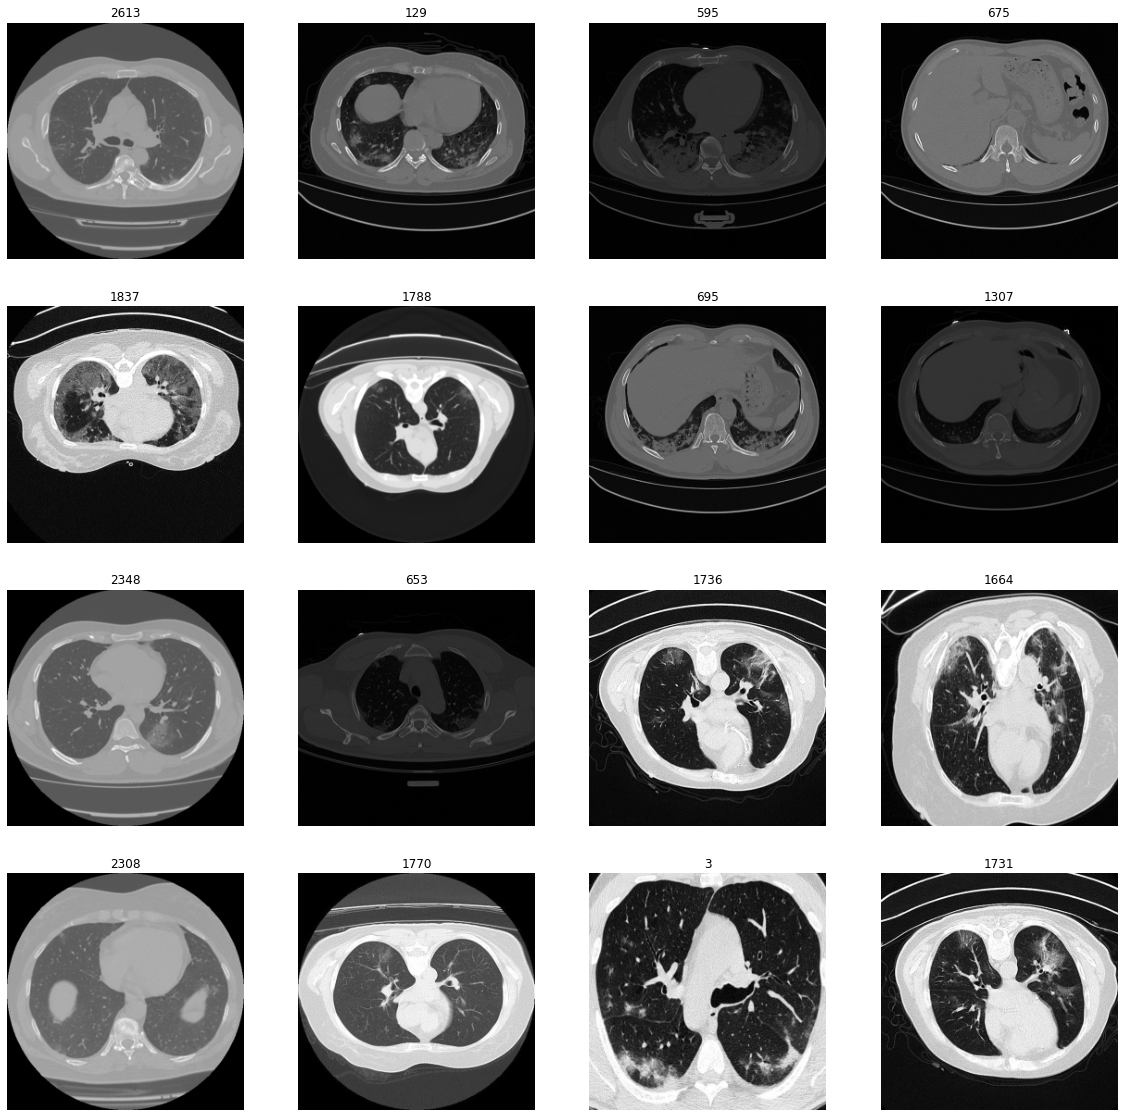

In [4]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

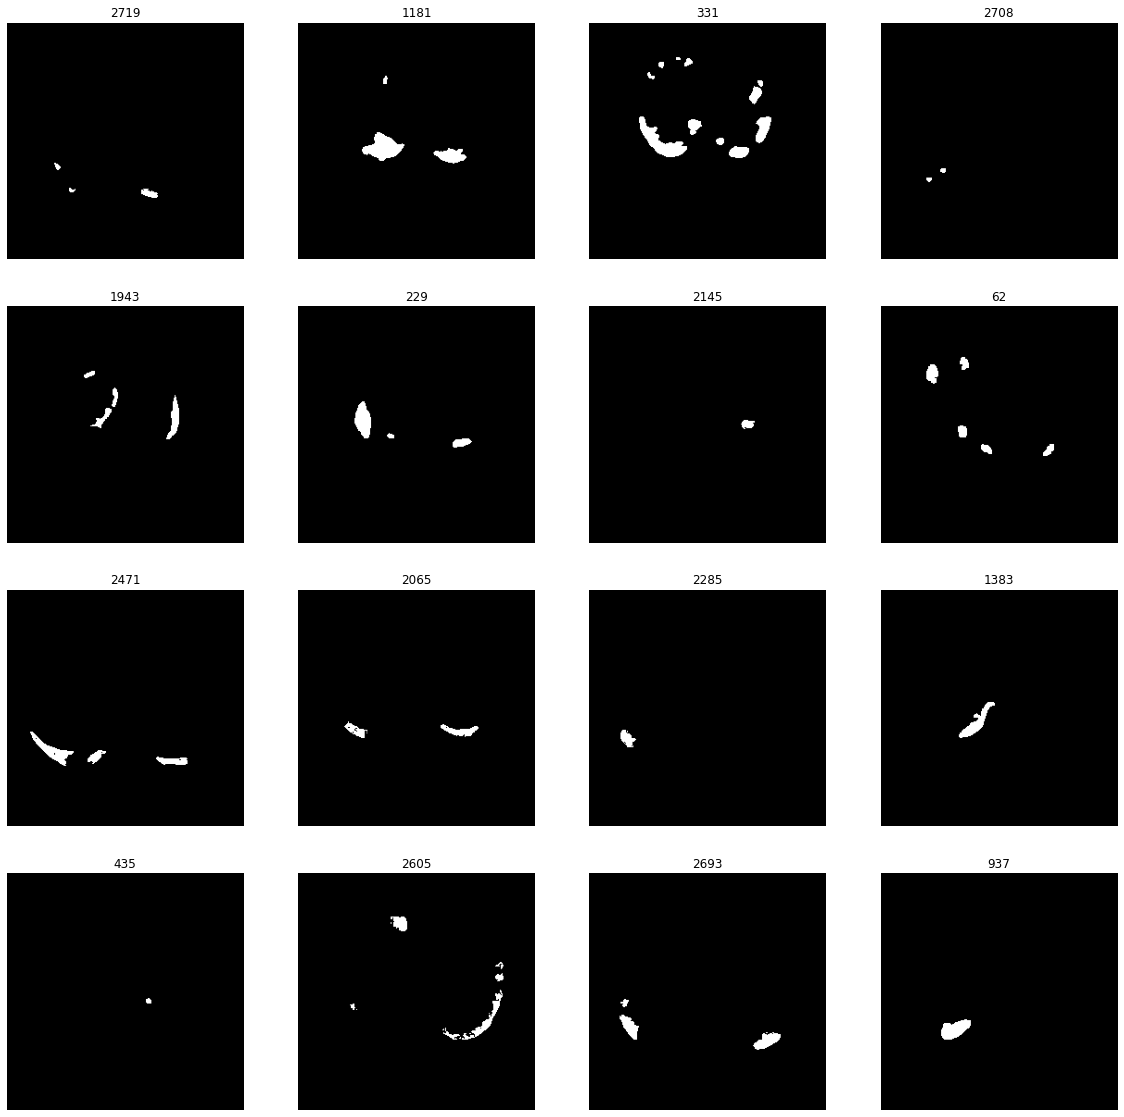

In [5]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(Y_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [6]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input ,Dropout ,Conv2DTranspose
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

In [7]:
def unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    model.summary()
    
    return model

In [8]:
model=unet(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [9]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [10]:
history=model.fit(X_train,Y_train,validation_split=0.1,batch_size=32,steps_per_epoch=len(X_train)//32,epochs=10,
                 callbacks=callback,verbose=1)

Epoch 1/10
85/85 [==============================] - 1710s 20s/step - loss: 0.5145 - accuracy: 0.9628 - val_loss: 0.1008 - val_accuracy: 0.9935

Epoch 00001: val_loss improved from inf to 0.10077, saving model to model.hdf5
Epoch 2/10
85/85 [==============================] - 3253s 39s/step - loss: 0.2772 - accuracy: 0.9820 - val_loss: 0.1008 - val_accuracy: 0.9935

Epoch 00002: val_loss improved from 0.10077 to 0.10076, saving model to model.hdf5
Epoch 3/10
85/85 [==============================] - 1672s 20s/step - loss: 0.2674 - accuracy: 0.9827 - val_loss: 0.1008 - val_accuracy: 0.9935

Epoch 00003: val_loss improved from 0.10076 to 0.10076, saving model to model.hdf5
Epoch 4/10
85/85 [==============================] - 1746s 21s/step - loss: 0.2761 - accuracy: 0.9821 - val_loss: 0.1008 - val_accuracy: 0.9935

Epoch 00004: val_loss improved from 0.10076 to 0.10076, saving model to model.hdf5
Epoch 5/10
85/85 [==============================] - 1750s 21s/step - loss: 0.2742 - accuracy: 0.

In [11]:
y_pred=model.predict(X_train)

In [12]:
print('Prediction Shape is {}'.format(y_pred.shape))

Prediction Shape is (2729, 256, 256, 1)


In [23]:
Pred_PATH =r'D:\dataset seg2/'
X_pred=[]
files=gb.glob(Pred_PATH+r'\pred_data\*.png')
for file in files :
    img =cv2.imread(file,0)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
    X_pred.append(list(img)) 
    

In [24]:
print(f'we have {len(X_pred)} items in X_pred')

we have 48 items in X_pred


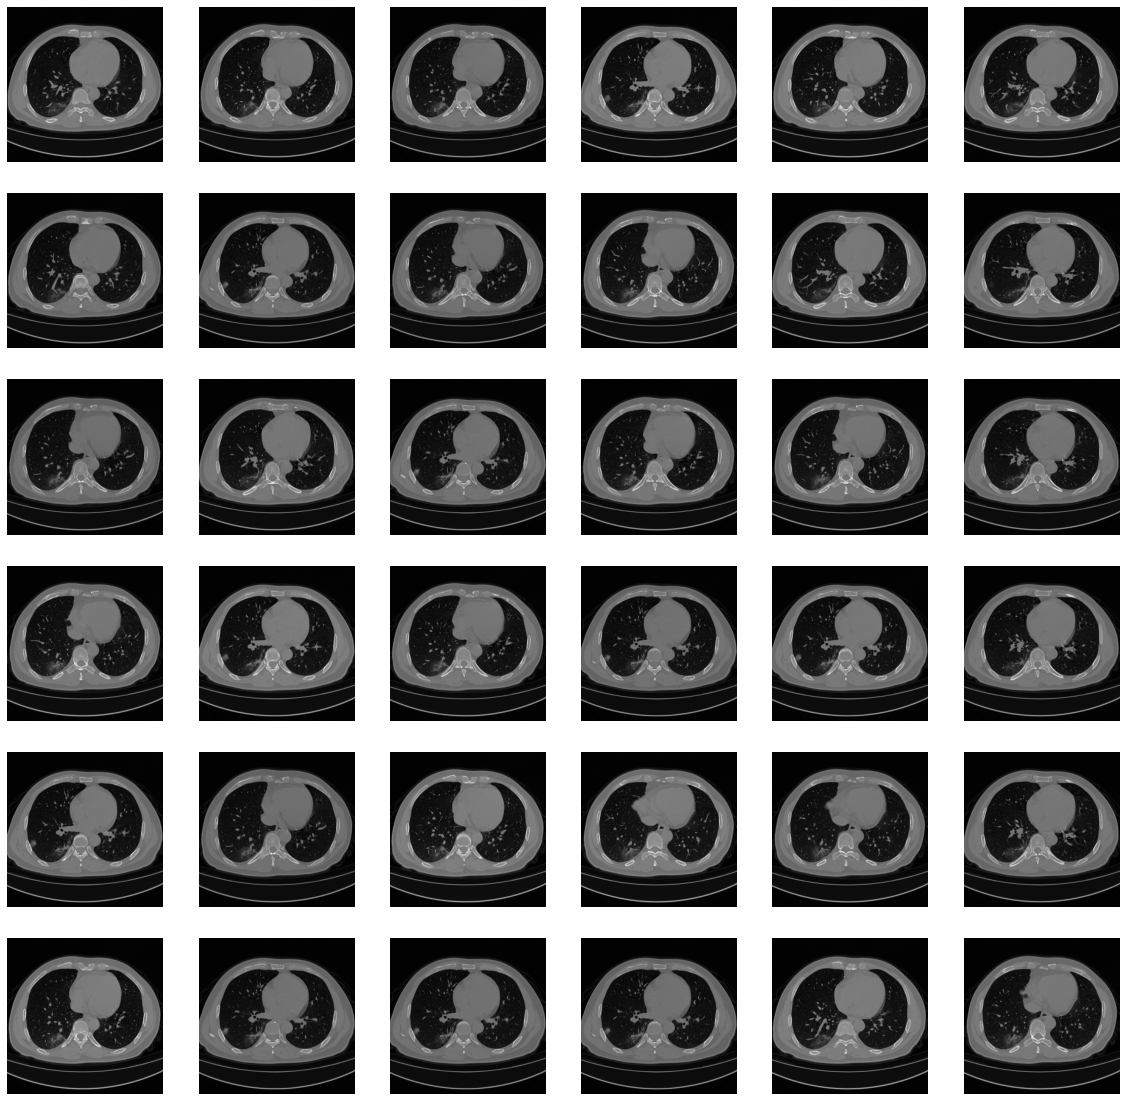

In [25]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_pred),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_pred[i],cmap='gray')    
    plt.axis('off')

In [26]:
X_pred_array = np.array(X_pred)

In [27]:
print(f'X_pred shape  is {X_pred_array.shape}')

X_pred shape  is (48, 256, 256)


In [28]:
y_result = model.predict(X_pred_array)

print('Prediction Shape is {}'.format(y_result.shape))

Prediction Shape is (48, 256, 256, 1)


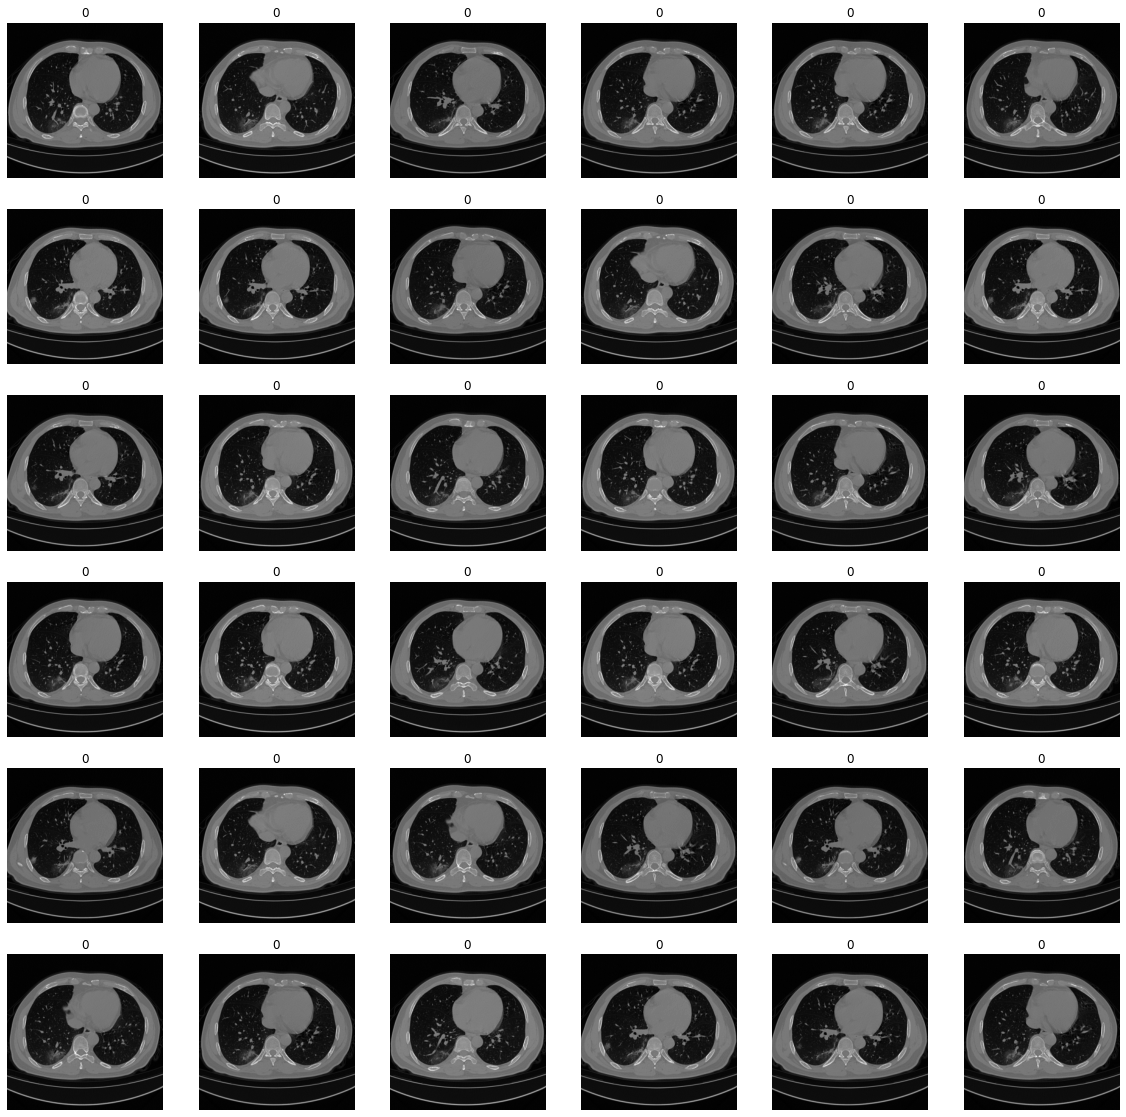

In [29]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_pred),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_pred[i],cmap='gray')    
    plt.axis('off')
    plt.title(np.argmax(y_result[i]))

In [30]:
y_pred_p=(y_pred > 0.5).astype(np.uint8)

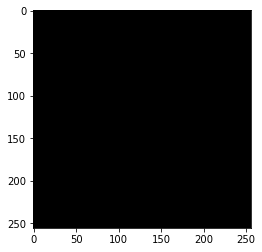

In [31]:
plt.imshow(y_pred_p[0],cmap='gray')